## Datasets
- Os dados sobre Bitcoin, Ibovespa,VIX e Dolar foram obtido no site Yahoo Finance
- Taxa Selic - Dados diários;Filtros aplicados: Data inicial: 01/11/2013 / Data final: 02/09/2022. <br>
LINK https://www.bcb.gov.br/htms/SELIC/SELICdiarios.asp?frame=1

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from finta import TA

### Constants and Parameters

In [3]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2020.03.31'
TRAIN_END = '2021.05.31'
TIMES = 3

### Auxiliary functions

In [4]:
def calculateEMA(df, n, columns):
    """
    returns an n period exponential moving average for
    the time series s

    pd.Dataframe df: is the original dataframe - it needs to contain a 'Close' named column
    int          n: is the number of periods to consider in the calculus

    returns a dataframe with a new column containing the MME
    """
    
    k  = 2 / (n+1)
    for column in columns:
        EMAcolumn = 'EMA_'+column

        df[EMAcolumn] = df[column]
        df[EMAcolumn].iloc[n-1] = df[column].iloc[0:n-2].mean()

        for i in range(n, len(df)):
            df[EMAcolumn].iloc[i] = (df[column].iloc[i] - df[EMAcolumn].iloc[i-1])*k + df[EMAcolumn].iloc[i-1]
            #MME = (Close[i] - MME[i-1])*k + MME[i-1] 
     
    #The following function makes all the hardwork. However I'll keep it commented, once I've already implemented the calculation
    #f['pandasEMA'] = df['close'].ewm(span=5, adjust=False).mean()
    
    return df

def calculateBB(df, n, columns):
    for column in columns:
        ma = df['close'].rolling(window=n).mean()
        std = df['close'].rolling(window=n).std() 
    
        df['UB_'+column] = ma + (std * 2)
        df['LB_'+column] = ma - (std * 2)
    
    return df

def removeColumns(df, columns):
    df = df.drop(columns, axis=1)
    return df

def addPreviousDays(df, days, columns):
    auxDf = df
    for day in range(1,days+1):
        for column in columns:
            colName = 'd-'+str(day)+'_'+column
            df[colName] = auxDf[column].shift(day)
    return df

def getPeriod(df, begin, end, resetIndex = False):
    """
    returns the df in the chosen interval
    
    Object begin: Start date forrmated as 'yyyy.mm.dd'
    Object   end: end date 'yyyy.mm.dd'

    returns a dataframe with the historic of the selected period
    """
    indexBegin = df[df['date']>=begin].index[0]
    indexEnd = df[df['date']>=end].index[0]
    if (resetIndex):
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)].reset_index(drop=True)
    else: 
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)]
    
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100, np.std(np.abs((actual - pred) / actual)) * 100

def mae(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred)), np.std(np.abs(actual - pred))

def Normalize(df):
    date = df['date']
    maxVal = df[['high', 'low']].max()
    normalized = removeColumns(df,['date'])/(removeColumns(df,['date']).max()*2)
    
    
    df.loc[:, df.columns != 'date'] = normalized
    
    return df, maxVal

def createDate(day, month, year):
    if(day >= 10):
        day = str(day)
    else:
        day = '0' + str(day)
    
    if(month < 10):
        month = '0' + str(month)
    else:
        month = str(month)
        
    year = str(year)
    date = year + '.' + month + '.' + day
    
    return date

def getDate(date):
    
    split = date.split('.')
    
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    
    return year, month, day
 
def printResult(error, column):
    print(column+': '+str(error[0].round(2))+' +- '+str(error[1].round(2)) + ' %')

### Opening the dataset

In [5]:
df = pd.read_csv('Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df2 = pd.read_csv('Data/VALE3_Daily.csv', sep = "\t")

df2.columns = dfColumns
df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

df 
df.tail(290)


,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


In [6]:
df['ema21'] = TA.EMA(df, column='close', period=21)
df['ema9'] = TA.EMA(df, column='close', period=9)
bb = TA.BBANDS(df, column='close', period=9)
df = pd.concat([df, bb], axis=1)
df['RSI'] = TA.RSI(df, column='close', period=9)
df['RSI-30'] = 30
df['RSI-70'] = 70


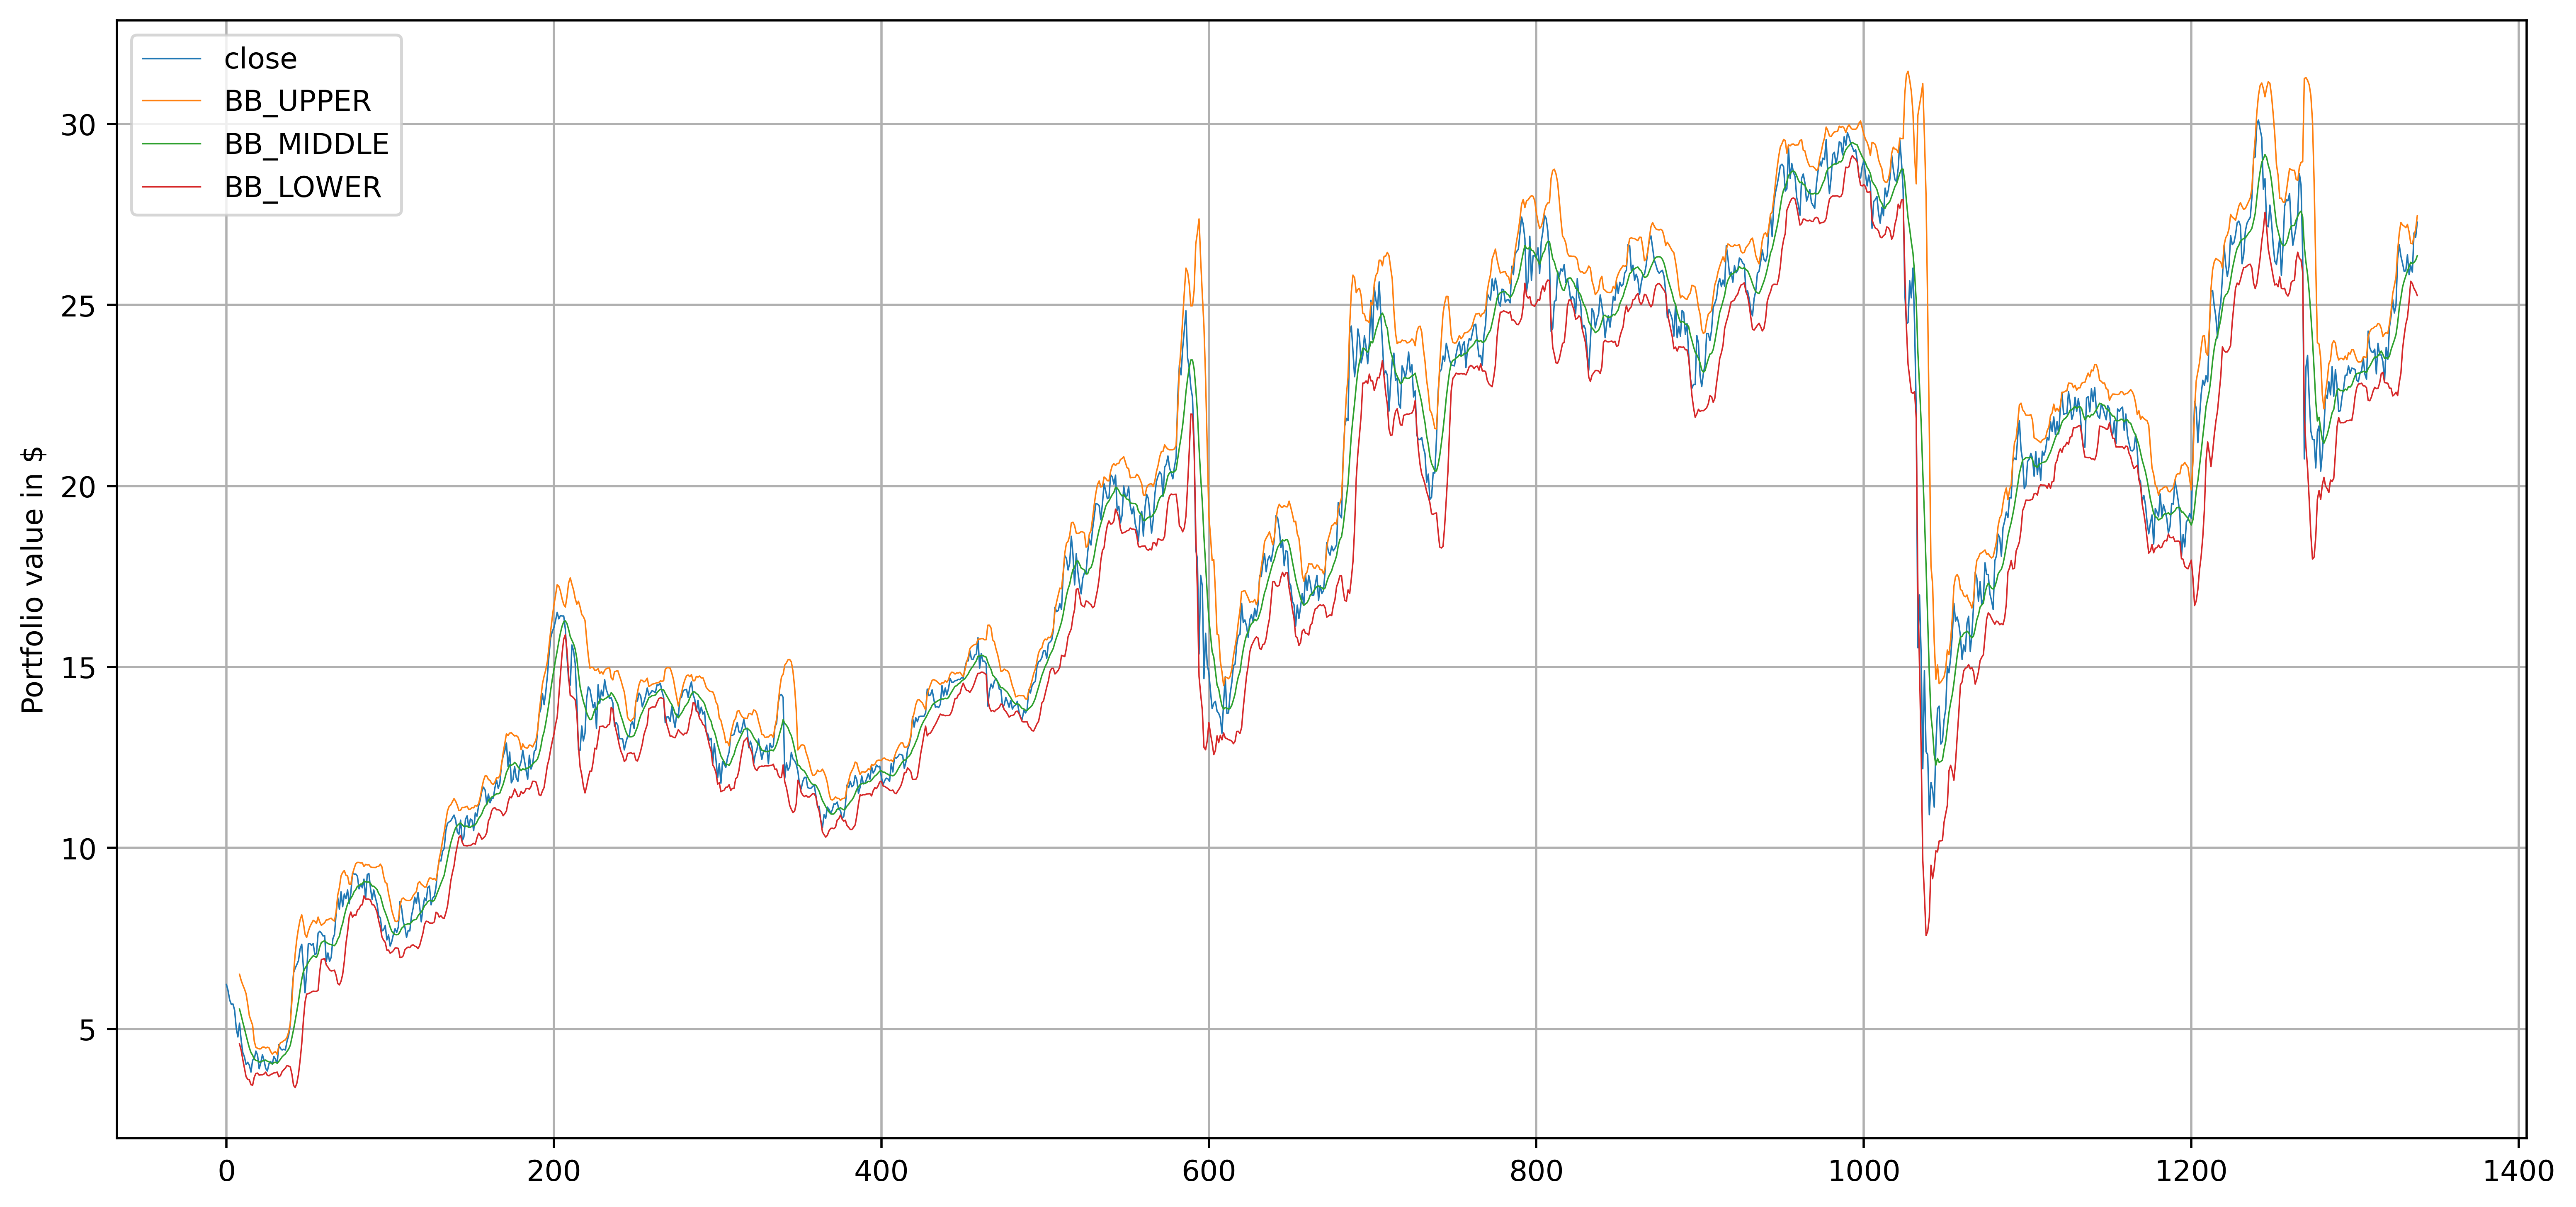

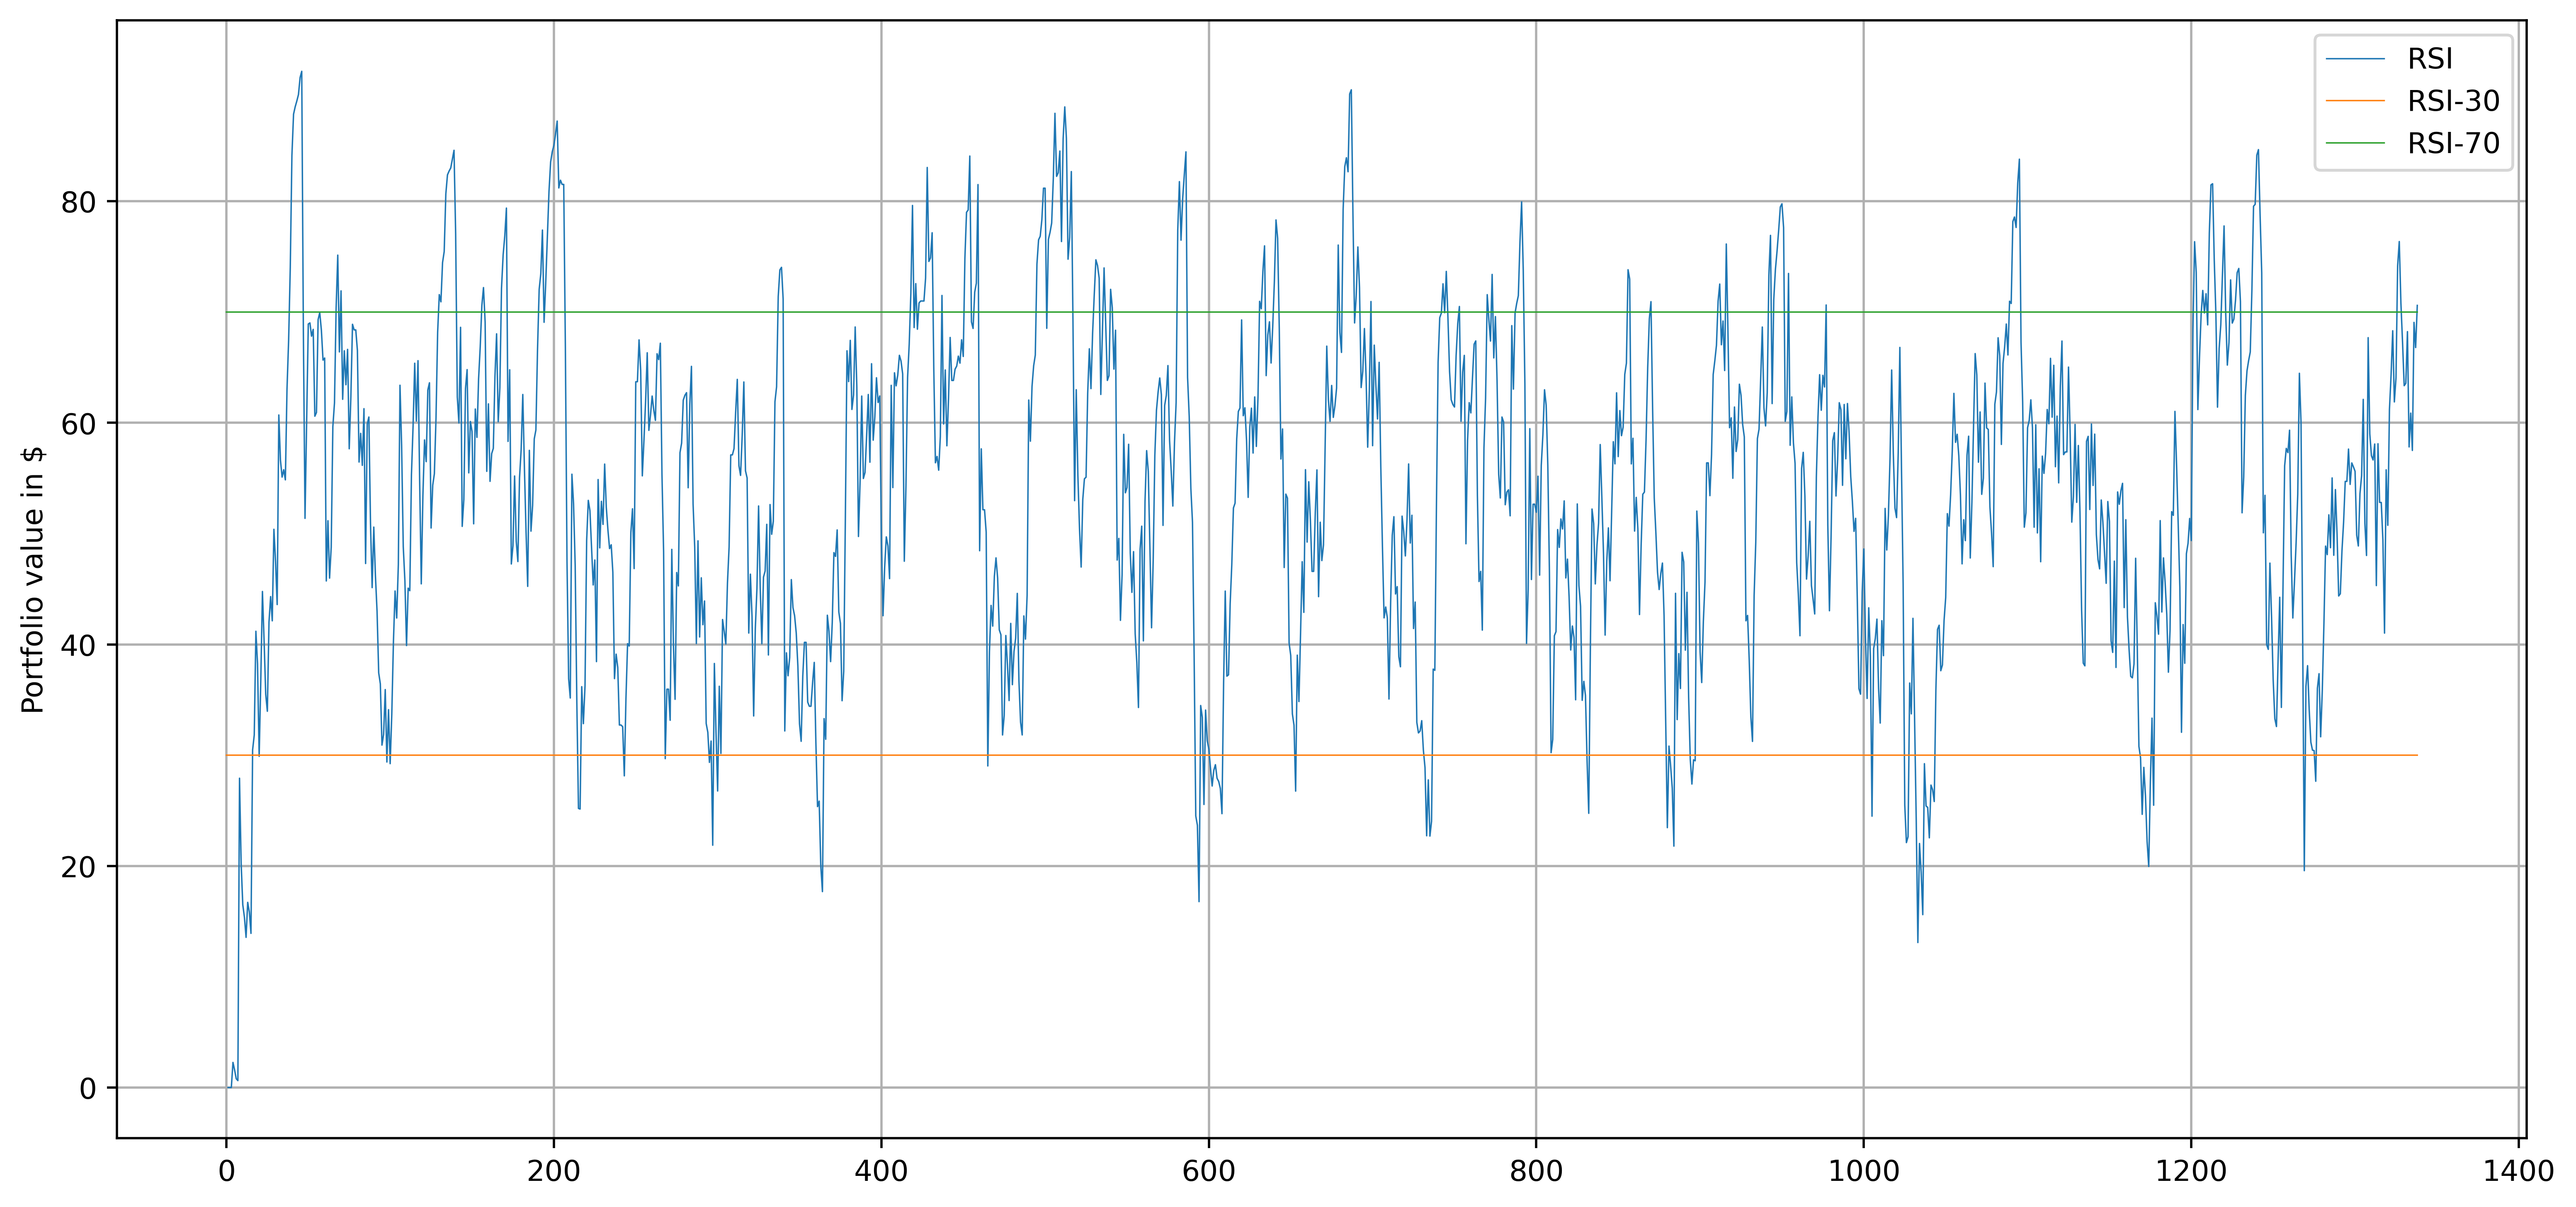

In [7]:
def showLineChart(df, columns):
    fig = plt.figure(figsize=(15,7), dpi=500)

    ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
    # df.set_index('index', inplace = True)


    df[columns].plot(ax=ax1, lw=0.5)
    # # Show the plot
    plt.grid()
    plt.show()
showLineChart(df, ['close','BB_UPPER', 'BB_MIDDLE', 'BB_LOWER'])
showLineChart(df, ['RSI','RSI-30','RSI-70'])

In [8]:
initialDf_PETR4 = getPeriod(df, '2019.01.02','2021.06.01', True)
initialDf_VALE3 = getPeriod(df2, '2019.01.02','2021.06.01', True)

In [8]:
# obtendo indicadores externos
def allColumnsToLower(df):
    columnHash = {}
    for columnName in df.columns:
        columnHash[columnName] = columnName.lower()
    df = df.rename(columnHash, axis=1) 
    return df

def parseDate(str:str):
    return str.replace('-','.')

df_VIX = pd.read_csv('Data/externalIndex/^VIX.csv', sep = ",")
df_VIX = df_VIX.dropna()
df_VIX = allColumnsToLower(df_VIX)
df_VIX = removeColumns(df_VIX, ['adj close', 'volume'])
df_VIX['date'] = df_VIX['date'].map(parseDate)

df_BVSP = pd.read_csv('Data/externalIndex/^BVSP.csv', sep = ",")
df_BVSP = df_BVSP.dropna()
df_BVSP = allColumnsToLower(df_BVSP)
df_BVSP = removeColumns(df_BVSP, ['adj close', 'volume'])
df_BVSP['date'] = df_BVSP['date'].map(parseDate)

df_DOLAR = pd.read_csv('Data/externalIndex/BRL=X.csv', sep = ",")
df_DOLAR = df_DOLAR.dropna()
df_DOLAR = allColumnsToLower(df_DOLAR)
df_DOLAR = removeColumns(df_DOLAR, ['adj close', 'volume'])
df_DOLAR['date'] = df_DOLAR['date'].map(parseDate)

df_BTC = pd.read_csv('Data/externalIndex/BTC-USD.csv', sep = ",")
df_BTC = df_BTC.dropna()
df_BTC = allColumnsToLower(df_BTC)
df_BTC = removeColumns(df_BTC, ['adj close', 'volume'])
df_BTC['date'] = df_BTC['date'].map(parseDate)




In [ ]:
#VIX
df_VIX = calculateEMA(df_VIX,DAYS,newColumns)
df_VIX = calculateBB(df_VIX,DAYS,newColumns)
df_VIX = addPreviousDays(df_VIX,DAYS, newColumns)

#DOLAR
df_DOLAR = calculateEMA(df_DOLAR,DAYS,newColumns)
df_DOLAR = calculateBB(df_DOLAR,DAYS,newColumns)
df_DOLAR = addPreviousDays(df_DOLAR,DAYS, newColumns)

#IBOVESPA
df_BVSP = calculateEMA(df_BVSP,DAYS,newColumns)
df_BVSP = calculateBB(df_BVSP,DAYS,newColumns)
df_BVSP = addPreviousDays(df_BVSP,DAYS, newColumns)

#BITCOIN
df_BTC = calculateEMA(df_BTC,DAYS,newColumns)
df_BTC = calculateBB(df_BTC,DAYS,newColumns)
df_BTC = addPreviousDays(df_BTC,DAYS, newColumns)



#### Experimento 01: Utilizando Random Forest Sem indicadores externos
##### Hipóteses plausíveis de serem testadas
1. Se construirmos um regressor só para a baixa e um regressor só para alta melhoramos nossa precisão?

In [9]:
def exp04(df, inputColumns = []):
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        trainColumns = [column for column in inputColumns if not column in ['date']]
        x_train = df_train[trainColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]


    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(x_train, y_train);

    y_pred = rf.predict(x_test)
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    return errorMax, errorMin, rf, x_train.columns

In [10]:
df

,date,open,high,low,close,ema21,ema9,BB_UPPER,BB_MIDDLE,BB_LOWER,RSI,RSI-30,RSI-70
0,2016.01.04,5.96,6.38,5.94,6.23,6.230000,6.230000,NaN,NaN,NaN,NaN,30,70
1,2016.01.05,6.28,6.35,6.00,6.06,6.140952,6.135556,NaN,NaN,NaN,0.000000,30,70
2,2016.01.06,5.92,5.93,5.80,5.80,6.016314,5.998033,NaN,NaN,NaN,0.000000,30,70
3,2016.01.07,5.61,5.83,5.51,5.68,5.919862,5.890298,NaN,NaN,NaN,0.000000,30,70
4,2016.01.08,5.79,5.85,5.56,5.69,5.864738,5.830714,NaN,NaN,NaN,2.265030,30,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09,25.217443,25.883399,26.708224,26.182222,25.656221,60.877353,30,70
1335,2021.05.27,26.08,26.25,25.77,25.91,25.280403,25.888719,26.690060,26.141111,25.592163,57.507198,30,70
1336,2021.05.28,26.20,27.02,26.15,26.99,25.435821,26.108975,26.899566,26.177778,25.455990,69.066410,30,70
1337,2021.05.31,26.96,27.20,26.78,26.87,25.566201,26.261180,27.090372,26.235556,25.380739,66.795145,30,70


In [ ]:

def test30timesExp04(df, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4, rf, _ = exp04(df)
        else: 
            errorMax_petr4, errorMin_petr4, rf, _ = exp04(df, columnInput)
            
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
        
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
test30timesExp04(initialDf_PETR4, 'PETR4 15 Variables', col15) 
test30timesExp04(initialDf_PETR4, 'PETR4 25 Variables', col25) 
test30timesExp04(initialDf_PETR4, 'PETR4 33 Variables') 
print('\n')
test30timesExp04(initialDf_VALE3, 'VALE3 15 Variables', col15) 
test30timesExp04(initialDf_VALE3, 'VALE3 25 Variables', col25) 
test30timesExp04(initialDf_VALE3, 'VALE3 33 Variables')     

PETR4 15 Variables
High: 0.34 +- 0.0 %
Low: 0.25 +- 0.0 %
PETR4 25 Variables
High: 0.35 +- 0.0 %
Low: 0.26 +- 0.0 %
PETR4 33 Variables
High: 0.33 +- 0.01 %
Low: 0.24 +- 0.01 %


VALE3 15 Variables
High: 0.38 +- 0.0 %
Low: 0.31 +- 0.0 %
VALE3 25 Variables
High: 0.38 +- 0.01 %
Low: 0.32 +- 0.0 %
VALE3 33 Variables
High: 0.38 +- 0.01 %
Low: 0.32 +- 0.01 %


In [ ]:
# dfWithAllowedColumns = initialDf_PETR4.drop(['high', 'low', 'close'], axis=1)
_,_,rf,xTrainColumns = exp04(initialDf_PETR4)

# importance = rf.feature_importances_
featureImp = []
for feat, importance in zip(xTrainColumns, rf.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (fT_df.sort_values('Importance', ascending = False))

      Feature  Importance
0        open   72.420379
4   EMA_close   10.071194
16  d-1_close    4.482062
3     EMA_low    3.186298
15    d-1_low    2.146630
2    EMA_high    1.867851
14   d-1_high    1.681553
1    EMA_open    1.249366
5     UB_open    0.425030
7     UB_high    0.412165
11   UB_close    0.398028
9      UB_low    0.321792
12   LB_close    0.197100
10     LB_low    0.161570
13   d-1_open    0.152736
20  d-2_close    0.112181
6     LB_open    0.100311
8     LB_high    0.071381
32  d-5_close    0.069793
26   d-4_high    0.064698
29   d-5_open    0.061331
18   d-2_high    0.054999
28  d-4_close    0.039085
27    d-4_low    0.038905
17   d-2_open    0.034150
19    d-2_low    0.030779
31    d-5_low    0.028753
22   d-3_high    0.027489
25   d-4_open    0.023370
24  d-3_close    0.019079
23    d-3_low    0.018097
30   d-5_high    0.017872
21   d-3_open    0.013972


#### Experimento 02: Utilizando Random Forest com indicadores externos
##### Hipóteses plausíveis de serem testadas

In [ ]:
PETR4WithExternalIndex = {}
PETR4WithExternalIndex['PETR4Dolar'] = initialDf_PETR4.merge(df_DOLAR, how='inner', on='date', suffixes=('', '_dolar'))
PETR4WithExternalIndex['PETR4VIX'] = initialDf_PETR4.merge(df_VIX, how='inner', on='date', suffixes=('', '_vix'))
PETR4WithExternalIndex['PETR4BTC'] = initialDf_PETR4.merge(df_BTC, how='inner', on='date', suffixes=('', '_BTC'))
PETR4WithExternalIndex['PETR4BVSP'] = initialDf_PETR4.merge(df_BVSP, how='inner', on='date', suffixes=('', '_BVSP'))



#### Verificando importância do Dólar, VIX, BVSP e BTC no Random Forest Regression

In [ ]:
for label in ['PETR4Dolar', 'PETR4VIX', 'PETR4BTC', 'PETR4BVSP']:
    print(f"Analisando influencia da feature {label}")
    bd = PETR4WithExternalIndex[label]
    _,_,rf, trainColumns = exp04(bd)

    # importance = rf.feature_importances_
    featureImp = []
    for feat, importance in zip(trainColumns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    print (fT_df.sort_values('Importance', ascending = False))

Analisando influencia da feature PETR4Dolar
            Feature  Importance
0              open   74.483056
4         EMA_close    8.294937
16        d-1_close    4.913432
3           EMA_low    2.268795
2          EMA_high    1.810565
..              ...         ...
43    UB_high_dolar    0.008408
52  d-1_close_dolar    0.008125
41    UB_open_dolar    0.008002
51    d-1_low_dolar    0.005594
49   d-1_open_dolar    0.005498

[69 rows x 2 columns]
Analisando influencia da feature PETR4VIX
         Feature  Importance
0           open   74.819820
4      EMA_close    9.458493
16     d-1_close    4.418276
3        EMA_low    2.583768
2       EMA_high    1.708625
..           ...         ...
62  d-4_high_vix    0.009390
25      d-4_open    0.008285
66  d-5_high_vix    0.008149
23       d-3_low    0.007648
67   d-5_low_vix    0.007067

[69 rows x 2 columns]
Analisando influencia da feature PETR4BTC
          Feature  Importance
0            open   74.414527
4       EMA_close    9.001889
16  